http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#sphx-glr-auto-examples-text-document-classification-20newsgroups-py

In [9]:
%matplotlib inline


# Classification of text documents using sparse features


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.

The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



In [10]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
print ("libraries loaded.")

libraries loaded.


In [23]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")
print ("op : ", op)
print ("options added.")

op :  <optparse.OptionParser object at 0x0000020D92637B00>
options added.


In [25]:
#(opts, args) = op.parse_args()
(opts, args) = op.parse_args(["--report"])
#https://docs.python.org/2/library/optparse.html
#deprecated. ssd by argparse
#https://docs.python.org/2/library/argparse.html#module-argparse
print ("opts : ", type(opts))
print ("args : ", type(args), "len(args) :", len(args))
print ("args : ", args)
print ("opts : ", opts)


if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)
print ("_____________________")
print(__doc__)
op.print_help()
print()


opts :  <class 'optparse.Values'>
args :  <class 'list'> len(args) : 0
args :  []
opts :  {'print_report': True, 'select_chi2': None, 'print_cm': None, 'print_top10': None, 'all_categories': None, 'use_hashing': None, 'n_features': 65536, 'filtered': None}
_____________________
Automatically created module for IPython interactive environment
Usage: __main__.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing v

Load some categories from the training set


In [26]:
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

In [27]:
print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

#http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
#sklearn.datasets.fetch_20newsgroups(data_home=None, 
#                                    subset='train', 
#                                    categories=None, 
#                                    shuffle=True, 
#                                    random_state=42, 
#                                    remove=(), 
#                                    download_if_missing=True)
#
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

2017-05-05 16:12:29,108 INFO Downloading 20news dataset. This may take a few minutes.
2017-05-05 16:12:29,113 WARNING Downloading dataset from http://people.csail.mit.edu/jrennie/20Newsgroups/20news-bydate.tar.gz (14 MB)


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


2017-05-05 16:12:34,539 INFO Decompressing C:\Users\username\scikit_learn_data\20news_home\20news-bydate.tar.gz


data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories



In [28]:
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print ("y_train : ", type(y_train), y_train.shape)
print ("y_test : ", type(y_test), y_test.shape)


y_train :  <class 'numpy.ndarray'> (2034,)
y_test :  <class 'numpy.ndarray'> (1353,)


In [29]:

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', non_negative=True,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 1.129016s at 3.525MB/s
n_samples: 2034, n_features: 33809



In [30]:

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the test data using the same vectorizer
done in 0.606562s at 4.727MB/s
n_samples: 1353, n_features: 33809



In [31]:
# mapping from integer feature name to original token string
if opts.use_hashing:
    print ("opts.use_hashing = True")
    feature_names = None
else:
    print ("opts.use_hashing != True")
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    print ("feature_names != false, converting feature_names=numpy.array")
    feature_names = np.asarray(feature_names)

print ("feature_names : ", type(feature_names))

opts.use_hashing != True
feature_names != false, converting feature_names=numpy.array
feature_names :  <class 'numpy.ndarray'>


In [32]:

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."
print ("function trim defined.")

function trim defined.


Benchmark classifiers


In [33]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
print ("function benchmark defined")


function benchmark defined


In [34]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


C:\Users\username\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.493s
test time:  0.010s
accuracy:   0.898
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.90      0.98      0.94       389
         sci.space       0.96      0.95      0.95       394
talk.religion.misc       0.83      0.78      0.80       251

       avg / total       0.90      0.90      0.90      1353


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.278s
test time:  0.004s
accuracy:   0.885
dimensionality: 33809
density: 0.240165

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.85      0.81      0.83   

In [35]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))
print ("results : ", type(results))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.001, verbose=0)


C:\Users\username\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.467s
test time:  0.003s
accuracy:   0.900
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.91      0.98      0.95       389
         sci.space       0.96      0.95      0.95       394
talk.religion.misc       0.83      0.79      0.81       251

       avg / total       0.90      0.90      0.90      1353


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.270s
test time:  0.004s
accuracy:   0.902
dimensionality: 33809
density: 0.669814

classification report:
       

C:\Users\username\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.461s
test time:  0.004s
accuracy:   0.873
dimensionality: 33809
density: 0.005553

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.85      0.75      0.80       319
     comp.graphics       0.89      0.97      0.93       389
         sci.space       0.94      0.94      0.94       394
talk.religion.misc       0.76      0.78      0.77       251

       avg / total       0.87      0.87      0.87      1353


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.731s
test time:  0.005s
accuracy:   0.886
dimensionality: 33809
density: 0.019810

classification report:
       

In [36]:

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))
print ("results : ", type(results))

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 1.012s
test time:  0.004s
accuracy:   0.899
dimensionality: 33809
density: 0.187768

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.92      0.98      0.95       389
         sci.space       0.95      0.94      0.95       394
talk.religion.misc       0.81      0.80      0.80       251

       avg / total       0.90      0.90      0.90      1353


results :  <class 'list'>


In [ ]:
# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

In [37]:

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.042s
test time:  0.008s
accuracy:   0.899
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.85      0.87      0.86       319
     comp.graphics       0.95      0.95      0.95       389
         sci.space       0.92      0.95      0.94       394
talk.religion.misc       0.86      0.77      0.81       251

       avg / total       0.90      0.90      0.90      1353


________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.021s
test time:  0.016s
accuracy:   0.884
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       

In [38]:
print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)), ('classification', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
train time: 0.568s
test time:  0.010s
accuracy:   0.880
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.80      0.82       319
     comp.graphics       0.91      0.96      0.93       389
         sci.space       0.92      0.95      0.93       394
talk.religion.misc       0.80      0.75      0.78     

C:\Users\username\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\username\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


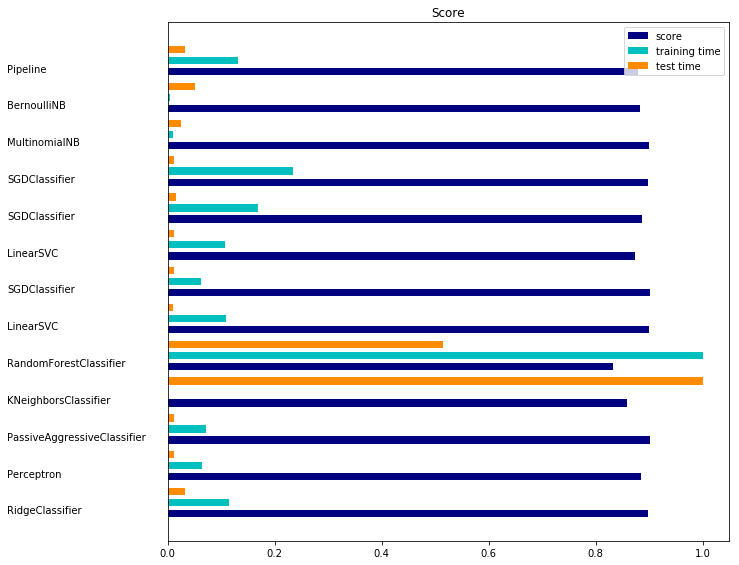

In [39]:
# make some plots
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()